In [79]:
# all libraries
from PIL import Image
import numpy as np
from scipy.fftpack import dct
import heapq
from collections import defaultdict
import os
import numpy as np
from scipy.fftpack import idct
import matplotlib.pyplot as plt
import huffman

- Image Processing

In [80]:
import numpy as np
from PIL import Image

def image_process(image_path):
    
    image = Image.open(image_path)
    
    image_rgb = image.convert('RGB')
    
    image_array = np.array(image_rgb).astype(np.int32)


    # Convert RGB to YCbCr
    Y = 0.299 * image_array[:, :, 0] + 0.587 * image_array[:, :, 1] + 0.114 * image_array[:, :, 2]
    Cb = -0.168736 * image_array[:, :, 0] - 0.331264 * image_array[:, :, 1] + 0.5 * image_array[:, :, 2] + 128
    Cr = 0.5 * image_array[:, :, 0] - 0.418688 * image_array[:, :, 1] - 0.081312 * image_array[:, :, 2] + 128

    # Create the Y, Cb, Cr channels

    Y_channel = Y.astype(np.float64)
    Cb_channel = Cb.astype(np.float64)
    Cr_channel = Cr.astype(np.float64)

    print("Y_channel range : ", np.min(Y_channel), np.max(Y_channel))
    print("Cb_channel range : ", np.min(Cb_channel), np.max(Cb_channel))
    print("Cr_channel range : ", np.min(Cr_channel), np.max(Cr_channel))

    
    Y_channel -= 128.0
    Cb_channel -= 128.0
    Cr_channel -= 128.0

    # Pad the image to make the dimensions divisible by 2
    pad_height = (2 - (Y_channel.shape[0] % 2)) % 2
    pad_width = (2 - (Y_channel.shape[1] % 2)) % 2

    
    Cb_channel_padded = np.pad(Cb_channel, ((0, pad_height), (0, pad_width)), mode="edge")
    Cr_channel_padded = np.pad(Cr_channel, ((0, pad_height), (0, pad_width)), mode="edge")

    
    def downsample_avg(channel):
        return (channel[::2, ::2] + channel[1::2, ::2] + channel[::2, 1::2] + channel[1::2, 1::2]) / 4

    Cb_downsampled = downsample_avg(Cb_channel_padded)
    Cr_downsampled = downsample_avg(Cr_channel_padded)

    pad_height = (8 - (Cb_downsampled.shape[0] % 8)) % 8
    pad_width = (8 - (Cb_downsampled.shape[1] % 8)) % 8
    pad_height_Y = (8 - (Y_channel.shape[0] % 8)) % 8
    pad_width_Y = (8 - (Y_channel.shape[1] % 8)) % 8

    Y_channel_padded = np.pad(Y_channel, ((0, pad_height_Y), (0, pad_width_Y)), mode="edge")
    Cb_downsampled_padded = np.pad(Cb_downsampled, ((0, pad_height), (0, pad_width)), mode="constant", constant_values=0)
    Cr_downsampled_padded = np.pad(Cr_downsampled, ((0, pad_height), (0, pad_width)), mode="constant", constant_values=0)

    return Y_channel_padded, Cb_downsampled_padded, Cr_downsampled_padded, [Y_channel.shape, Cb_downsampled.shape]


- dct_mat computation

In [81]:
def compute_dct_mat(image, qmat):
    dct_mat_coeff_quant = np.zeros((8, image.shape[1]*image.shape[0]//8))
    for i in range(image.shape[0]//8):
        for j in range(image.shape[1]//8):
            block = image[8*i:8*i+8, 8*j: 8*j+8]
            dct_mat_coeff_quant[:, image.shape[1]*i + 8*j : image.shape[1]*i + 8*(j+1)] = np.round(dct(dct(block.T, norm="ortho").T, norm="ortho") / qmat).astype(int)

    return dct_mat_coeff_quant
    

- Huffman encoding 

In [82]:
class HuffmanNode:
    def __init__(self, symbol, freq):
        self.symbol = symbol
        self.freq = freq
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.freq < other.freq

def build_huffman_tree(freq_table):
    heap = [HuffmanNode(sym, freq) for sym, freq in freq_table.items()]
    heapq.heapify(heap)

    while len(heap) > 1:
        left = heapq.heappop(heap)
        right = heapq.heappop(heap)
        merged = HuffmanNode(None, left.freq + right.freq)
        merged.left = left
        merged.right = right
        heapq.heappush(heap, merged)
    return heap[0]

def generate_huffman_codes(freq_table):
    codes = {}
    tree = build_huffman_tree(freq_table)
    def generate_codes_helper(node, current_code):
        if node.symbol is not None:
            codes[node.symbol] = current_code
            return
        generate_codes_helper(node.left, current_code + "0")
        generate_codes_helper(node.right, current_code + "1")

    generate_codes_helper(tree, "")
    return codes

- Run length Encoding

In [83]:
def zigzag_order(n):
    indices = [(x, y) for x in range(n) for y in range(n)]
    zigzag_indices = sorted(indices, key=lambda x: (x[0] + x[1], -x[0] if (x[0] + x[1]) % 2 == 0 else x[0]))
    return zigzag_indices

def run_length_encode(zigzag_block, huffman_codes):
    encoded = []
    run_length = 0

    for coefficient in zigzag_block:
        if coefficient == 0:
            run_length += 1
        else:
            size = len(huffman_codes[coefficient]) 
            while run_length > 15:  
                encoded.append((15, 0, None))  
                run_length -= 15
            encoded.append((run_length, size, huffman_codes[coefficient]))
            run_length = 0
    
    encoded.append((0, 0, None))  # EOB marker
    return encoded

- Entropy encoding

In [84]:
def encode(dct_mat):

    # calc diff
    dct_mat_diff = dct_mat - np.roll(dct_mat, 8, axis=1)
    dct_mat_diff[:,:8] = dct_mat[:,:8]
    
    # get huffman for all blocks
    unique_values, counts = np.unique(dct_mat_diff, return_counts=True)
    freq_table = list(zip(unique_values, counts))
    freq_table = [item for item in freq_table if item[0] != 0]
    # huffman_codes = generate_huffman_codes(freq_table)
    huffman_codes = dict(huffman.codebook(freq_table))
    
    encoded = []
    # run length code
    zigzag_ind = zigzag_order(8)
    for i in range(dct_mat_diff.shape[1]//8):
        block = dct_mat_diff[:, 8*i:8*i+8]
        zigzag_block = [block[x, y] for x, y in zigzag_ind]
        encoded_block = run_length_encode(zigzag_block, huffman_codes)
        encoded += encoded_block
        
    return encoded, huffman_codes


- Saving in a file

In [85]:
import numpy as np
import struct
from bitstring import BitArray

def write_compressed_file(filename, qL, qC, hufftableY, hufftableC, encodingY, encodingC, sz, is_color=True):
    with open(filename, 'wb') as f:
        
        # file size and image dimension
        file_size = 0  
        f.write(struct.pack('>I', file_size)) 
        # color flag
        color_flag = 1 if is_color else 0
        f.write(struct.pack('>B', color_flag))

        f.write(struct.pack('>H', sz[0][0]))
        f.write(struct.pack('>H', sz[0][1]))
        f.write(struct.pack('>H', sz[1][0]))
        f.write(struct.pack('>H', sz[1][1]))
        
        # ##### Luminance #####

        # huffman table for Y
        huffman_list = list(hufftableY.items())
        huff_bstream = BitArray()
        f.write(struct.pack('>I', len(huffman_list))) 
        for coeff, huff_code in huffman_list:
            coeff_bit = BitArray(int=coeff, length=12)
            huff_len_bit = BitArray(uint=len(huff_code), length=8)
            huff_bit = BitArray(bin=huff_code)
            huff_bstream += coeff_bit + huff_len_bit + huff_bit
        huff_bstream.tofile(f)
        
        # quantization matrix
        qL.byteswap().newbyteorder().tofile(f)  # Write the quantization matrix as raw binary data
        
        # RLE 
        f.write(struct.pack('>I', len(encodingY)))  # Big-endian for unsigned int
        final_bitstream = BitArray()
        bitstream_len = 0
        for run_len, code_len, huff_code in encodingY:
            run_len_bit = BitArray(uint=run_len, length=4)
            code_len_bit = BitArray(uint=code_len, length=8)
            if huff_code is None:
                final_bitstream += run_len_bit + code_len_bit
                continue
            huff_code_bit = BitArray(bin=huff_code)
            final_bitstream += run_len_bit + code_len_bit + huff_code_bit
            bitstream_len += 12 + code_len
        final_bitstream.tofile(f)
        
        
        # ##### Chrominance #####

        # huffman table for C
        huffman_list = list(hufftableC.items())
        huff_bstream = BitArray()
        f.write(struct.pack('>I', len(huffman_list))) 
        for coeff, huff_code in huffman_list:
            coeff_bit = BitArray(int=coeff, length=12)
            huff_len_bit = BitArray(uint=len(huff_code), length=8)
            huff_bit = BitArray(bin=huff_code)
            huff_bstream += coeff_bit + huff_len_bit + huff_bit
        huff_bstream.tofile(f)
        
        # quantization matrix
        qC.byteswap().newbyteorder().tofile(f)  # Write the quantization matrix as raw binary data
        
        # RLE 
        f.write(struct.pack('>I', len(encodingC)))  # Big-endian for unsigned int
        final_bitstream = BitArray()
        bitstream_len = 0
        for run_len, code_len, huff_code in encodingC:
            run_len_bit = BitArray(uint=run_len, length=4)
            code_len_bit = BitArray(uint=code_len, length=8)
            if huff_code is None:
                final_bitstream += run_len_bit + code_len_bit
                continue
            huff_code_bit = BitArray(bin=huff_code)
            final_bitstream += run_len_bit + code_len_bit + huff_code_bit
            bitstream_len += 8 + code_len
        final_bitstream.tofile(f)

        current_position = f.tell()
        f.seek(0)
        f.write(struct.pack('>I', current_position))
        f.seek(current_position)
        


- reading file

In [86]:
from bitstring import ConstBitStream
import numpy as np

def read_compressed_file(filename):
    with open(filename, 'rb') as f:
        
        bitstream = ConstBitStream(f)

        # File size
        file_size = bitstream.read('uint:32')
        
        # Color flag
        color_flag = bitstream.read('uint:8')
        is_color = True if color_flag == 1 else False

        #  image dimension
        heightY = bitstream.read('uint:16')
        widthY = bitstream.read('uint:16')
        heightC = bitstream.read('uint:16')
        widthC = bitstream.read('uint:16')

        # Huffman table Y
        num_entries = bitstream.read('uint:32')
        huffman_tableY = {}
        total_bits_read = 0
        for _ in range(num_entries):
            coeff = bitstream.read('int:12')
            huff_code_len = bitstream.read('uint:8')
            huff_code = bitstream.read(f'bin:{huff_code_len}')
            huffman_tableY[huff_code] = coeff
            total_bits_read = (total_bits_read + 20 + huff_code_len) % 8
        if total_bits_read:
            bitstream.read(f'int:{8-total_bits_read}')
            
        # Quantization matrix
        quant_matrix_size = 64  
        quant_matrixY = np.zeros((8, 8), dtype=np.int16)
        for i in range(quant_matrix_size):
            quant_matrixY[i // 8, i % 8] = bitstream.read('uint:16')  

        # RLE
        encoded_data_len = bitstream.read('uint:32')
        run_length_encodingY = []
        total_bits_read = 0
        for _ in range(encoded_data_len):
            run_len = bitstream.read('uint:4')
            code_len = bitstream.read('uint:8')
            total_bits_read = (total_bits_read + 12) % 8
            if code_len > 0:
                huff_code = bitstream.read(f'bin:{code_len}')
                total_bits_read = (total_bits_read + code_len) % 8
            else:
                huff_code = None
            run_length_encodingY.append((run_len, code_len, huff_code))
        if total_bits_read:
            bitstream.read(f'int:{8-total_bits_read}')


        # Huffman table C
        num_entries = bitstream.read('uint:32')
        huffman_tableC = {}
        total_bits_read = 0
        for _ in range(num_entries):
            coeff = bitstream.read('int:12')
            huff_code_len = bitstream.read('uint:8')
            huff_code = bitstream.read(f'bin:{huff_code_len}')
            huffman_tableC[huff_code] = coeff
            total_bits_read = (total_bits_read + 20 + huff_code_len) % 8
        if total_bits_read:
            bitstream.read(f'int:{8-total_bits_read}')
            
        # Quantization matrix
        quant_matrix_size = 64  
        quant_matrixC = np.zeros((8, 8), dtype=np.int16)
        for i in range(quant_matrix_size):
            quant_matrixC[i // 8, i % 8] = bitstream.read('uint:16')  

        # RLE
        encoded_data_len = bitstream.read('uint:32')
        run_length_encodingC = []
        for _ in range(encoded_data_len):
            run_len = bitstream.read('uint:4')
            code_len = bitstream.read('uint:8')
            if code_len > 0:
                huff_code = bitstream.read(f'bin:{code_len}') 
            else:
                huff_code = None
            run_length_encodingC.append((run_len, code_len, huff_code))
        

        return quant_matrixY, quant_matrixC, huffman_tableY, huffman_tableC, run_length_encodingY, run_length_encodingC, [[heightY, widthY], [heightC, widthC]]




- decoding run length encoding

In [87]:
def decode_rle_data(encoded_data, huffman_table, sz):
    pad_height = (8 - (sz[0] % 8)) % 8
    pad_width = (8 - (sz[1] % 8)) % 8
    dct_mat = np.zeros([sz[0]+pad_height, sz[1]+pad_width])
    edind = 0
    prev_block = np.zeros([8,8])
    zigzag_ind = zigzag_order(8)
    
    for i in range(dct_mat.shape[0]//8):
        for j in range(dct_mat.shape[1]//8):
            block = np.zeros([8,8])
            ind = 0
            while(encoded_data[edind][1] or encoded_data[edind][0]):
                ind += encoded_data[edind][0]
                if(encoded_data[edind][1]):
                    block[zigzag_ind[ind]] = huffman_table[encoded_data[edind][2]]
                    ind+=1
                edind+=1
            edind+=1
            
            dct_mat[i*8:(i+1)*8, j*8:(j+1)*8] = prev_block + block
            prev_block = dct_mat[i*8:(i+1)*8, j*8:(j+1)*8]
    
    return dct_mat


- Inverse dct_mat + Post processing

In [88]:
def compute_Idct_mat(dct_mat_coeff_quant, qmat):
    image = np.zeros(dct_mat_coeff_quant.shape)
    for i in range(image.shape[0] // 8):
        for j in range(image.shape[1] // 8):
            coeff_block = dct_mat_coeff_quant[8*i:8*(i+1), 8*j : 8*(j+1)]
            
            dequantized_block = np.round(coeff_block * qmat).astype(int)
        
            block_idct_mat = idct(idct(dequantized_block.T, norm="ortho").T, norm="ortho")
        
            image[8*i:8*i+8, 8*j:8*j+8] = block_idct_mat

    return image

def ycbcr_to_rgb(Y, Cb, Cr):
    
    R = (Y + 1.402 * (Cr - 128))
    G = (Y - 0.344136 * (Cb - 128) - 0.714136 * (Cr - 128))
    B = (Y + 1.772 * (Cb - 128))
    
    R = np.clip(R, 0, 255).astype(np.uint8)
    G = np.clip(G, 0, 255).astype(np.uint8)
    B = np.clip(B, 0, 255).astype(np.uint8)
    
    return np.stack((R, G, B), axis=-1)

def post_process(Y, Cb, Cr):
    Y = np.clip((Y + 128), 0, 255)
    Cb = np.clip((Cb + 128), 0, 255)
    Cr = np.clip((Cr + 128), 0, 255)
    # Y = Y + 128
    # Cb = Cb + 128
    # Cr = Cr + 128
    
    # Convert YCbCr to RGB
    rgb_image = ycbcr_to_rgb(Y, Cb, Cr)
    print("Y range : ", np.min(Y), np.max(Y))
    print("Cb range : ", np.min(Cb), np.max(Cb))
    print("Cr range : ", np.min(Cr), np.max(Cr))
    return rgb_image


In [89]:
def compress(input_image_path, output_image_path, Q_factor):

    quant_luminance = np.array([[16, 11, 10, 16, 24, 40, 51, 61], 
                         [12, 12, 14, 19, 26, 58, 60, 55], 
                         [14, 13, 16, 24, 40, 57, 69, 56], 
                         [14, 17, 22, 29, 51, 87, 80, 62], 
                         [18, 22, 37, 56, 68, 109, 103, 77], 
                         [24, 35, 55, 64, 81, 104, 113, 92], 
                         [49, 64, 78, 87, 103, 121, 120, 101], 
                         [72, 92, 95, 98, 112, 100, 103, 99]])
    
    
    quant_chrominance = np.array([[17, 18, 24, 47, 99, 99, 99, 99],
                            [18, 21, 26, 66, 99, 99, 99, 99],
                            [24, 26, 56, 99, 99, 99, 99, 99],
                            [47, 66, 99, 99, 99, 99, 99, 99],
                            [99, 99, 99, 99, 99, 99, 99, 99],
                            [99, 99, 99, 99, 99, 99, 99, 99],
                            [99, 99, 99, 99, 99, 99, 99, 99],
                            [99, 99, 99, 99, 99, 99, 99, 99]])
    
    
    qL = (quant_luminance*(50/Q_factor)).astype(np.uint16)
    qC = (quant_chrominance*(50/Q_factor)).astype(np.uint16)
    
    Yimg, YCb, YCr, sz = image_process(input_image_path)
    Yc = np.concatenate([YCb, YCr], axis=0)
    print(np.min(Yimg), np.max(Yimg))
    print(np.min(YCb), np.max(YCb))
    print(np.min(YCr), np.max(YCr))
    dct_mat_Y = compute_dct_mat(Yimg.astype(np.int8), qL)
    dct_mat_Cb = compute_dct_mat(YCb.astype(np.int8), qC)
    dct_mat_Cr = compute_dct_mat(YCr.astype(np.int8), qC)

    dct_mat_C = compute_dct_mat(Yc, qC)



    encodingY, hufftableY = encode(dct_mat_Y)
    encodingC, hufftableC = encode(dct_mat_C)

    write_compressed_file(output_image_path, qL, qC, hufftableY, hufftableC, encodingY, encodingC, sz)

    fileSize = os.path.getsize(output_image_path) 
    
    return sz, fileSize, dct_mat_Y, dct_mat_C, dct_mat_Cb, dct_mat_Cr


- Decompress image

In [90]:
def decompress(filename):
    qY, qL, huffcodesY, huffcodesC, rleY, rleC, sz = read_compressed_file(filename)
    
    
    dct_matY = decode_rle_data(rleY, huffcodesY, sz[0])
    pad_height = (8 - (sz[1][0] % 8)) % 8
    pad_width = (8 - (sz[1][1] % 8)) % 8
    sznew = [2*(sz[1][0] + pad_height), sz[1][1] + pad_width]
    print("new sz : ", sznew)

    dct_matC = decode_rle_data(rleC, huffcodesC, sznew)
    print("after decompression : ", dct_matC.shape)
    dct_matCb = dct_matC[:dct_matC.shape[0]//2,:]
    dct_matCr = dct_matC[dct_matC.shape[0]//2:,:]

    idct_matY = compute_Idct_mat(dct_matY, qY)
    idct_matCb = compute_Idct_mat(dct_matCb, qL)
    idct_matCr = compute_Idct_mat(dct_matCr, qL)

    idct_matY_crop = idct_matY[:sz[0][0], :sz[0][1]]
    idct_matCb_crop = idct_matCb[:sz[1][0], :sz[1][1]]
    idct_matCr_crop = idct_matCr[:sz[1][0], :sz[1][1]]

    def upsample_avg(channel):

        upsampled_channel = np.zeros((channel.shape[0] * 2, channel.shape[1] * 2), dtype=np.int32)

        # Replicate each pixel in the downsampled image to a 2x2 block in the upsampled image
        upsampled_channel[::2, ::2] = channel
        upsampled_channel[1::2, ::2] = channel
        upsampled_channel[::2, 1::2] = channel
        upsampled_channel[1::2, 1::2] = channel

        return upsampled_channel

    idct_upsample_Cb = upsample_avg(idct_matCb_crop)
    idct_upsample_Cr = upsample_avg(idct_matCr_crop)

    idct_Cb_crop = idct_upsample_Cb[:sz[0][0], :sz[0][1]]
    idct_Cr_crop = idct_upsample_Cr[:sz[0][0], :sz[0][1]]

    print(sz, dct_matC.shape, dct_matY.shape, )
    recon_image = post_process(idct_matY_crop, idct_Cb_crop, idct_Cr_crop)

    return recon_image, dct_matY, dct_matCb, dct_matCr, dct_matC

Y_channel range :  0.0 255.0
Cb_channel range :  15.581823999999997 189.68003199999998
Cr_channel range :  50.70259200000001 229.0
-128.0 127.0
-93.06462400000001 55.581416000000004
-71.098056 86.97946400000001
[(639, 1096), (320, 548)] 321106
new sz :  [640, 552]
after decompression :  (640, 552)
[[639, 1096], [320, 548]] (640, 552) (640, 1096)
Y range :  0.0 255.0
Cb range :  34 189
Cr range :  47 217


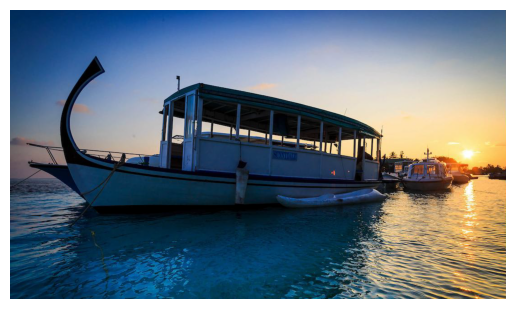

In [91]:
sz, fsz, dy, dc, dcb, dcr = compress("boat.png", "boat.ojpeg", 100)

print(sz, fsz)
image, dY, dCb, dCr, dC = decompress("boat.ojpeg")

plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()
